<a href="https://colab.research.google.com/github/bashar-z/portfolio-optimizer/blob/main/portfolio_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

== Max-Sharpe Allocation ==


,0
Ticker,
NVDA,0.350
PG,0.331
JPM,0.126
MSFT,0.116
AAPL,0.057
XOM,0.020
META,-0.000
GOOGL,-0.000
AMZN,-0.000



== Min-Variance Allocation ==


,0
Ticker,
PG,0.350
XOM,0.197
UNH,0.142
AMZN,0.114
JPM,0.079
GOOGL,0.068
MSFT,0.049
META,0.000
NVDA,0.000


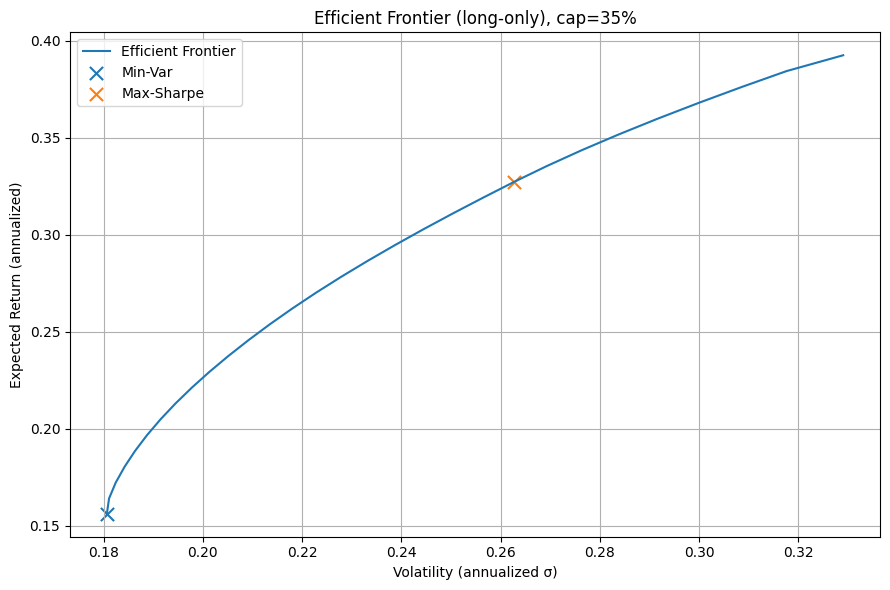

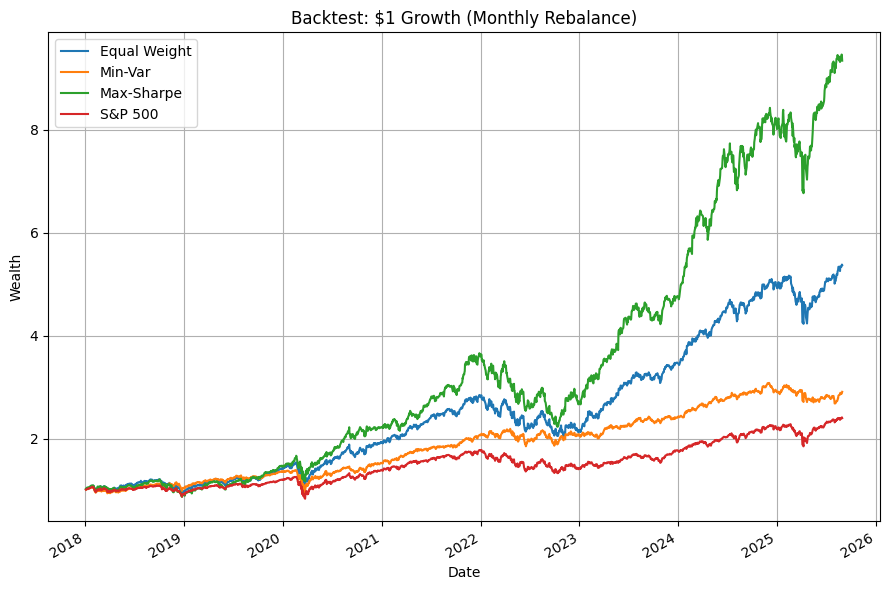

== Performance Summary (annualized) ==


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Equal Weight,24.63,23.08,106.71,-31.58
Min-Var,15.01,18.07,83.07,-31.01
Max-Sharpe,34.00,26.27,129.46,-39.06
S&P 500,12.13,19.89,60.98,-33.92



==== Quick Summary (copy for README/resume) ====
As-of: 2025-08-29
Universe: AAPL, MSFT, NVDA, AMZN, GOOGL, XOM, JPM, UNH, PG, META | Benchmark: S&P 500

Allocations (Top 5) - Max-Sharpe:
Ticker
NVDA    0.350
PG      0.331
JPM     0.126
MSFT    0.116
AAPL    0.057

Allocations (Top 5) - Min-Var:
Ticker
PG      0.350
XOM     0.197
UNH     0.142
AMZN    0.114
JPM     0.079

Expected (Annualized, from history):
  Max-Sharpe: Return 32.72%, Vol 26.27%, Sharpe 1.25
  Min-Var:    Return 15.61%, Vol 18.06%, Sharpe 0.86


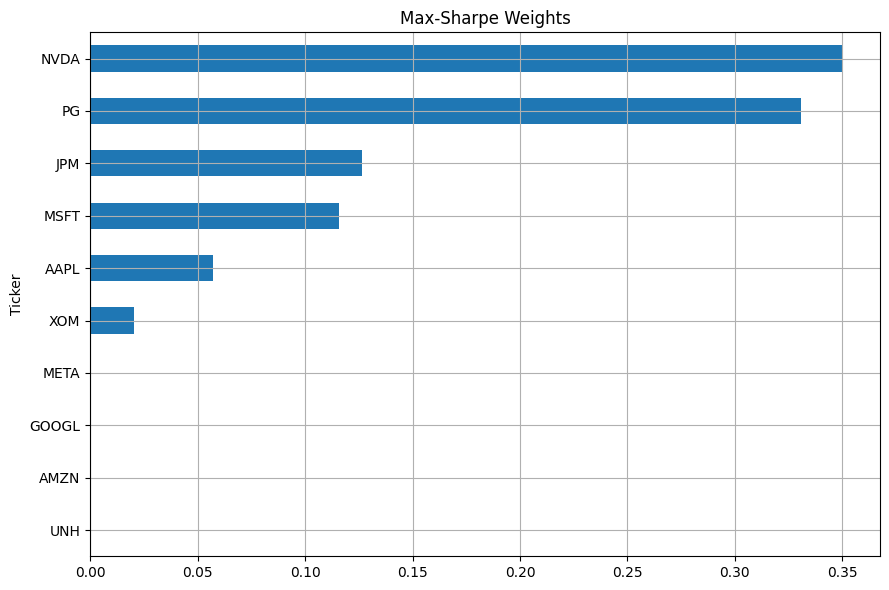


Saved figures: efficient_frontier.png, backtest_wealth.png, max_sharpe_weights.png


In [5]:
# =========================
# Portfolio Optimizer & Backtest (Colab one-cell script)
# =========================

# Installs
!pip -q install yfinance cvxpy pandas numpy matplotlib

# Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
from IPython.display import display
from datetime import datetime

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.grid'] = True

# -------------------------
# USER CONFIG
# -------------------------
TICKERS   = ["AAPL","MSFT","NVDA","AMZN","GOOGL","XOM","JPM","UNH","PG","META"]  # change if you want
BENCHMARK = "^GSPC"       # S&P 500
START     = "2018-01-01"
END       = None          # up to today
RISK_FREE = 0.00          # keep 0 for tonight
LONG_ONLY = True          # True = no shorting
WEIGHT_CAP = 0.35         # per-name cap (e.g., 0.20). Set to None to disable.
TRADING_DAYS = 252

# -------------------------
# DATA LOAD (robust to yfinance quirks)
# -------------------------
def get_prices(tickers, start, end):
    # auto_adjust=True gives adjusted Close in 'Close'
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        # try 'Close' on level 0
        if "Close" in df.columns.get_level_values(0):
            px = df["Close"]
        # or 'Close' on level 1 (some versions flip levels)
        elif "Close" in df.columns.get_level_values(1):
            px = df.xs("Close", axis=1, level=1)
        else:
            raise ValueError("Could not find 'Close' in downloaded data.")
    else:
        # single-level columns (likely single ticker)
        if "Close" in df.columns:
            px = df[["Close"]]
            if isinstance(tickers, (list, tuple)) and len(tickers) == 1:
                px.columns = [tickers[0]]
        else:
            raise ValueError("No 'Close' prices found.")
    # drop empty columns and rows with any NaNs
    px = px.dropna(axis=1, how="all").dropna(axis=0, how="any")
    return px

prices = get_prices(TICKERS, START, END)
bench  = get_prices([BENCHMARK], START, END).iloc[:,0]

# align indices
common_idx = prices.index.intersection(bench.index)
prices = prices.loc[common_idx]
bench  = bench.loc[common_idx]

if prices.shape[1] < 2:
    raise ValueError("Not enough valid price series. Try different tickers or date range.")

# -------------------------
# RETURNS & STATS
# -------------------------
rets_daily = prices.pct_change().dropna()
mu_daily   = rets_daily.mean()
cov_daily  = rets_daily.cov()

mu_annual  = mu_daily * TRADING_DAYS
cov_annual = cov_daily * TRADING_DAYS

def portfolio_stats(weights, mu, cov, rf=0.0):
    w = np.asarray(weights).ravel()
    ret = float(w @ mu.values)
    vol = float(np.sqrt(w @ cov.values @ w))
    shp = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, shp

# -------------------------
# OPTIMIZERS (DCP-safe)
# -------------------------
def solve_min_variance(mu, cov, long_only=True, w_cap=None):
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov.values))
    constraints = [cp.sum(w) == 1]
    if long_only:
        constraints += [w >= 0]
    if w_cap is not None:
        constraints += [w <= w_cap]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    if w.value is None:
        raise RuntimeError("Min-variance optimization failed.")
    return np.array(w.value).ravel()

def solve_min_var_for_target(mu, cov, target_return, long_only=True, w_cap=None):
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov.values))
    constraints = [cp.sum(w) == 1, mu.values @ w >= float(target_return)]
    if long_only:
        constraints += [w >= 0]
    if w_cap is not None:
        constraints += [w <= w_cap]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    if w.value is None:
        return None
    return np.array(w.value).ravel()

def solve_max_sharpe_via_frontier(mu, cov, rf=0.0, long_only=True, w_cap=None, n_points=60):
    # sweep reasonable targets across [min(mu), max(mu)]
    tmin, tmax = float(mu.min()), float(mu.max())
    # widen slightly in case all mus are clustered
    targets = np.linspace(tmin*0.9, tmax*1.1, n_points)

    best = {"sharpe": -np.inf, "w": None, "ret": None, "vol": None}
    frontier_pts = []
    for tr in targets:
        w = solve_min_var_for_target(mu, cov, tr, long_only=long_only, w_cap=w_cap)
        if w is None:
            continue
        ret, vol, shp = portfolio_stats(w, mu, cov, rf=rf)
        frontier_pts.append((vol, ret))
        if np.isfinite(shp) and shp > best["sharpe"]:
            best = {"sharpe": shp, "w": w, "ret": ret, "vol": vol}
    vols = np.array([v for v, r in frontier_pts])
    rets = np.array([r for v, r in frontier_pts])
    return best["w"], vols, rets, best

# -------------------------
# SOLVE PORTFOLIOS
# -------------------------
w_minvar = solve_min_variance(mu_annual, cov_annual, long_only=LONG_ONLY, w_cap=WEIGHT_CAP)
w_maxsharpe, frontier_vol, frontier_ret, best_info = solve_max_sharpe_via_frontier(
    mu_annual, cov_annual, rf=RISK_FREE, long_only=LONG_ONLY, w_cap=WEIGHT_CAP, n_points=70
)
if w_maxsharpe is None:
    # fallback: use min-var if frontier scan found nothing (very rare unless constraints too tight)
    w_maxsharpe = w_minvar

alloc_minvar    = pd.Series(w_minvar,    index=prices.columns).sort_values(ascending=False)
alloc_maxsharpe = pd.Series(w_maxsharpe, index=prices.columns).sort_values(ascending=False)

print("== Max-Sharpe Allocation ==")
display(alloc_maxsharpe.round(3))
print("\n== Min-Variance Allocation ==")
display(alloc_minvar.round(3))

# -------------------------
# EFFICIENT FRONTIER PLOT
# -------------------------
ret_mv, vol_mv, _ = portfolio_stats(w_minvar,    mu_annual, cov_annual, rf=RISK_FREE)
ret_ms, vol_ms, _ = portfolio_stats(w_maxsharpe, mu_annual, cov_annual, rf=RISK_FREE)

plt.figure()
if len(frontier_vol) > 0:
    plt.plot(frontier_vol, frontier_ret, label="Efficient Frontier")
plt.scatter(vol_mv, ret_mv, marker="x", s=90, label="Min-Var")
plt.scatter(vol_ms, ret_ms, marker="x", s=90, label="Max-Sharpe")
plt.xlabel("Volatility (annualized σ)")
plt.ylabel("Expected Return (annualized)")
title_extra = f", cap={WEIGHT_CAP:.0%}" if WEIGHT_CAP is not None else ""
plt.title("Efficient Frontier (long-only)" + title_extra)
plt.legend()
plt.tight_layout()
plt.savefig("efficient_frontier.png", dpi=150)
plt.show()

# -------------------------
# BACKTEST (monthly rebalance, static weights)
# -------------------------
def monthly_rebalance_backtest(prices_df, weights_series):
    """
    Simple backtest: static target weights; apply daily returns; rebalance at month-end (no costs).
    Since weights are static, rebalancing just resets to target monthly.
    """
    rets = prices_df.pct_change().dropna()
    month_end_idx = rets.resample("M").last().index
    w = weights_series.reindex(prices_df.columns).fillna(0.0).values

    wealth = []
    cur_wealth = 1.0
    for dt, row in rets.iterrows():
        if dt in month_end_idx:
            # (no transaction costs; just assume reset to target weights)
            pass
        cur_wealth *= (1.0 + float(np.dot(w, row.values)))
        wealth.append((dt, cur_wealth))
    return pd.Series([v for (_, v) in wealth], index=[d for (d, _) in wealth])

wealth_ew      = monthly_rebalance_backtest(prices, pd.Series(np.repeat(1/len(TICKERS), len(TICKERS)), index=prices.columns))
wealth_minvar  = monthly_rebalance_backtest(prices, alloc_minvar)
wealth_maxshrp = monthly_rebalance_backtest(prices, alloc_maxsharpe)

bench_rets   = bench.pct_change().dropna()
bench_wealth = (1.0 + bench_rets).cumprod()
bench_wealth = bench_wealth.reindex(wealth_ew.index, method="nearest").dropna()

# Plot wealth curves
plt.figure()
wealth_ew.plot(label="Equal Weight")
wealth_minvar.plot(label="Min-Var")
wealth_maxshrp.plot(label="Max-Sharpe")
bench_wealth.plot(label="S&P 500")
plt.title("Backtest: $1 Growth (Monthly Rebalance)")
plt.ylabel("Wealth")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig("backtest_wealth.png", dpi=150)
plt.show()

# -------------------------
# PERFORMANCE TABLE
# -------------------------
def perf_stats(wealth_series, rf=0.0):
    rets = wealth_series.pct_change().dropna()
    n_days = len(rets)
    if n_days == 0:
        return pd.Series({"Ann.Return": np.nan, "Ann.Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan})
    ann_ret = wealth_series.iloc[-1]**(TRADING_DAYS / n_days) - 1
    ann_vol = rets.std() * np.sqrt(TRADING_DAYS)
    sharpe  = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
    mdd     = ((wealth_series / wealth_series.cummax()) - 1).min()
    return pd.Series({"Ann.Return": ann_ret, "Ann.Vol": ann_vol, "Sharpe": sharpe, "MaxDD": mdd})

summary = pd.concat([
    perf_stats(wealth_ew, RISK_FREE).rename("Equal Weight"),
    perf_stats(wealth_minvar, RISK_FREE).rename("Min-Var"),
    perf_stats(wealth_maxshrp, RISK_FREE).rename("Max-Sharpe"),
    perf_stats(bench_wealth, RISK_FREE).rename("S&P 500"),
], axis=1).T

print("== Performance Summary (annualized) ==")
display((summary * 100).round(2))  # percentages for all except Sharpe (still multiplied but readable)

# -------------------------
# QUICK TEXT SUMMARY (for README / resume)
# -------------------------
def pct(x): return f"{x*100:.2f}%"
as_of = prices.index[-1].strftime("%Y-%m-%d")
ret_ms, vol_ms, sh_ms = portfolio_stats(w_maxsharpe, mu_annual, cov_annual, rf=RISK_FREE)
ret_mv, vol_mv, sh_mv = portfolio_stats(w_minvar,    mu_annual, cov_annual, rf=RISK_FREE)

print("\n==== Quick Summary (copy for README/resume) ====")
print(f"As-of: {as_of}")
print(f"Universe: {', '.join(TICKERS)} | Benchmark: S&P 500")
print("\nAllocations (Top 5) - Max-Sharpe:")
print(alloc_maxsharpe.head(5).round(3).to_string())
print("\nAllocations (Top 5) - Min-Var:")
print(alloc_minvar.head(5).round(3).to_string())
print("\nExpected (Annualized, from history):")
print(f"  Max-Sharpe: Return {pct(ret_ms)}, Vol {pct(vol_ms)}, Sharpe {sh_ms:.2f}")
print(f"  Min-Var:    Return {pct(ret_mv)}, Vol {pct(vol_mv)}, Sharpe {sh_mv:.2f}")

# Optional extra plot: Max-Sharpe weights barh
plt.figure()
alloc_maxsharpe.sort_values().plot(kind="barh", title="Max-Sharpe Weights")
plt.tight_layout()
plt.savefig("max_sharpe_weights.png", dpi=150)
plt.show()

print("\nSaved figures: efficient_frontier.png, backtest_wealth.png, max_sharpe_weights.png")
